# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [6]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:13<00:00, 4.31kFile/s]

Extracting celeba...


In [0]:
!pip install -q tqdm

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving helper.py to helper.py
Saving helper1.py to helper1.py
Saving problem_unittests.py to problem_unittests.py
User uploaded file "helper.py" with length 8116 bytes
User uploaded file "helper1.py" with length 8116 bytes
User uploaded file "problem_unittests.py" with length 6094 bytes


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

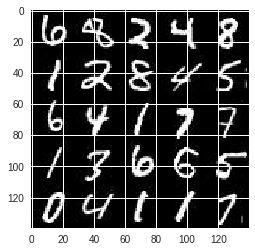

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

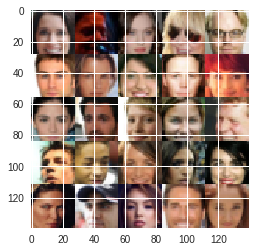

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    inputs_Z = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, None,"learning_rate")

    return inputs_real, inputs_Z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.9

    with tf.variable_scope('discriminator', reuse=reuse):
        d1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        d1 = tf.maximum(alpha * d1, d1)
        
        d2 = tf.layers.conv2d(d1, 128, 5, strides=2, padding='same', activation=None)
        d2 = tf.layers.batch_normalization(d2, training=True)
        d2 = tf.maximum(alpha * d2, d2)
        d2 = tf.nn.dropout(d2, keep_prob=keep_prob)
        
        d3 = tf.layers.conv2d(d2, 256, 5, strides=2, padding='same', activation=None)
        d3 = tf.layers.batch_normalization(d3, training=True)
        d3 = tf.maximum(alpha * d3, d3)
        d3 = tf.nn.dropout(d3, keep_prob=keep_prob)
        
        flat = tf.reshape(d3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 5, strides=1, padding='same', activation=None)
        
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_model_real)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake

    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    disc_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(gen_updates):
        gen_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=gen_vars)
        
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    n_images = 30
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % 20 == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                    if steps % 100 == 0:
                        show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 1.7108
Epoch 1/2... Discriminator Loss: 0.8155... Generator Loss: 1.2684
Epoch 1/2... Discriminator Loss: 0.8720... Generator Loss: 1.6214
Epoch 1/2... Discriminator Loss: 0.9293... Generator Loss: 1.0074


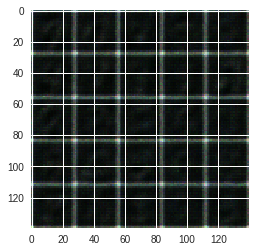

Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.4602
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 1.0208
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 0.5494
Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 1.3666


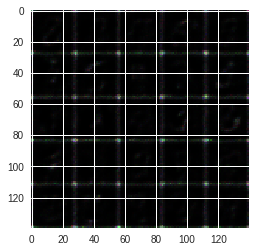

Epoch 1/2... Discriminator Loss: 1.1373... Generator Loss: 0.5919
Epoch 1/2... Discriminator Loss: 0.9101... Generator Loss: 0.9311
Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 1.9081
Epoch 1/2... Discriminator Loss: 0.6860... Generator Loss: 1.9227
Epoch 1/2... Discriminator Loss: 0.7351... Generator Loss: 2.1327


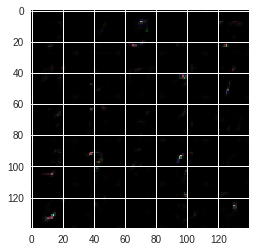

Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 0.7824
Epoch 1/2... Discriminator Loss: 0.6015... Generator Loss: 1.4714
Epoch 1/2... Discriminator Loss: 0.6298... Generator Loss: 2.2155
Epoch 1/2... Discriminator Loss: 0.7494... Generator Loss: 2.5680
Epoch 1/2... Discriminator Loss: 0.5900... Generator Loss: 1.1676


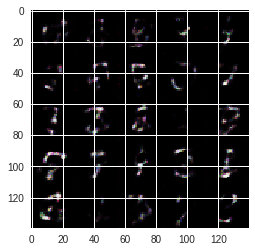

Epoch 1/2... Discriminator Loss: 0.5565... Generator Loss: 1.7160
Epoch 1/2... Discriminator Loss: 0.5984... Generator Loss: 1.7198
Epoch 1/2... Discriminator Loss: 0.7905... Generator Loss: 2.3334
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 0.6613... Generator Loss: 1.7262


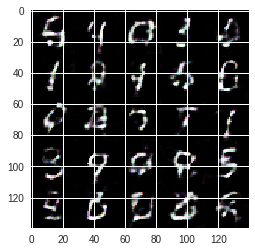

Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 1.4588
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 1.7442
Epoch 2/2... Discriminator Loss: 0.7937... Generator Loss: 1.7628
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 0.4419
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 1.2551


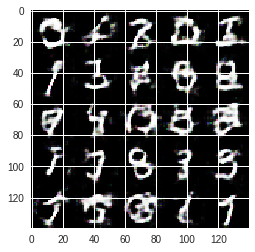

Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 1.9873
Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 1.9207
Epoch 2/2... Discriminator Loss: 0.8849... Generator Loss: 1.8049
Epoch 2/2... Discriminator Loss: 0.7324... Generator Loss: 1.1634
Epoch 2/2... Discriminator Loss: 0.6737... Generator Loss: 1.4677


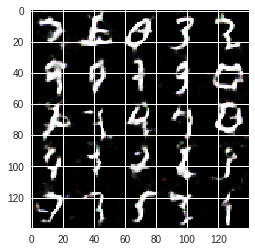

Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 0.9207
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 0.6087
Epoch 2/2... Discriminator Loss: 0.7772... Generator Loss: 1.0635
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 1.0170
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 2.6156


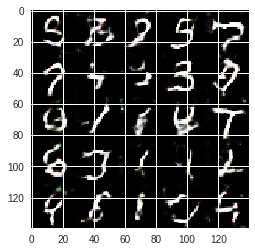

Epoch 2/2... Discriminator Loss: 0.7811... Generator Loss: 1.0487
Epoch 2/2... Discriminator Loss: 0.8244... Generator Loss: 1.4303
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 1.7924
Epoch 2/2... Discriminator Loss: 0.6365... Generator Loss: 1.5151


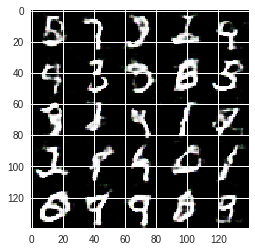

Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 0.8119


In [24]:
import helper1

batch_size = 128
z_dim = 110
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper1.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 1.3513
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 1.7886
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 1.7992
Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 1.3525


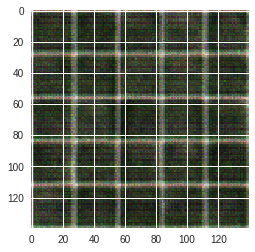

Epoch 1/1... Discriminator Loss: 0.2966... Generator Loss: 2.1582
Epoch 1/1... Discriminator Loss: 0.4170... Generator Loss: 4.8532
Epoch 1/1... Discriminator Loss: 0.2114... Generator Loss: 3.5005
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 5.3864
Epoch 1/1... Discriminator Loss: 0.2332... Generator Loss: 3.0291


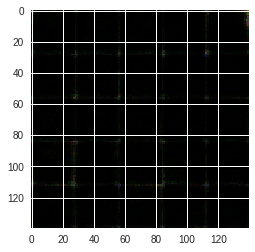

Epoch 1/1... Discriminator Loss: 0.3175... Generator Loss: 2.6264
Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 1.9100
Epoch 1/1... Discriminator Loss: 0.2305... Generator Loss: 2.6674
Epoch 1/1... Discriminator Loss: 0.2494... Generator Loss: 2.7713
Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 1.6966


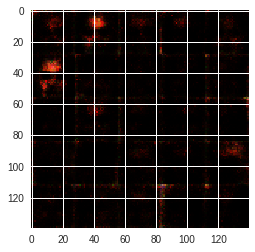

Epoch 1/1... Discriminator Loss: 0.2983... Generator Loss: 2.2521
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 1.6073
Epoch 1/1... Discriminator Loss: 0.3386... Generator Loss: 2.0605
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 1.9675


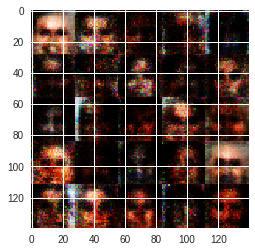

Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 1.4466
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 2.6015
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 2.9827
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 2.3558
Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 2.0166


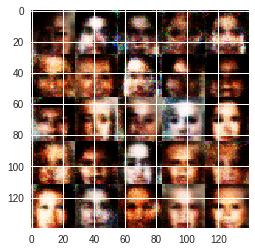

Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 2.3135
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 2.4481
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.5157


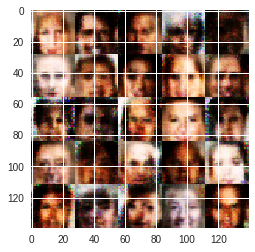

Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 2.1150
Epoch 1/1... Discriminator Loss: 0.6118... Generator Loss: 1.9635
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.4139


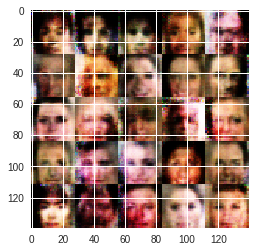

Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.4574
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.6011
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.0939


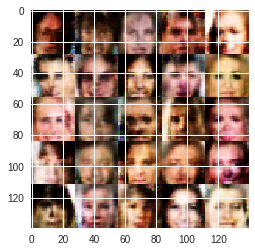

Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.3790
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.5299
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.6815


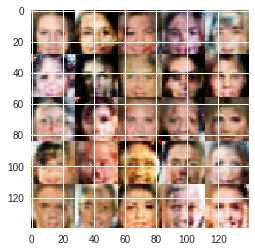

Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 1.6666
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.9225
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.0758


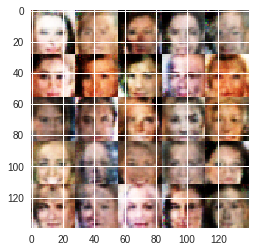

Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 1.1393


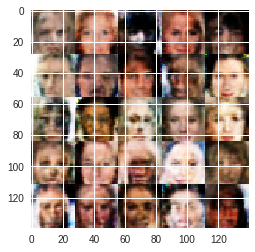

Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.2964
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.1829
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.3852


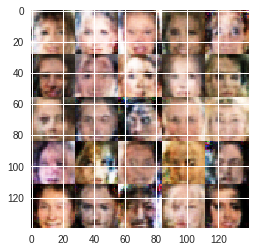

Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.8901
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.2952


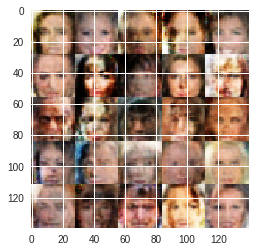

Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.4258
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.4101
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.0459


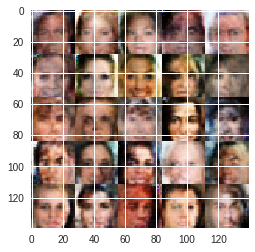

Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.1370


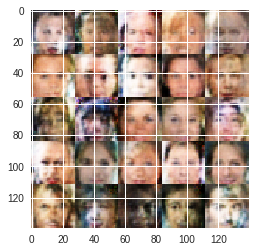

Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.7865


In [25]:
batch_size = 128
z_dim = 110
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.